### Setup

In [9]:
%run utils/utils_data_cleaning.py

import matplotlib.pyplot as plt

### Load a subset of the dataset

In [88]:
df = load_taxi_data_chunk(chunk=50000)
handle_missing_data(df)
df.head()

Data loaded with 50000 entries and 10 columns
Size reduction from 50000 to 48804 (1196 samples dropped for missing data)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


In [6]:
import pickle as pkl

file_indices = [i + (616 if i>260 else 0) for i in range(696)][:100]
n_files = len(file_indices)
print('Number of chunks =',n_files)

df = pd.DataFrame()
for chunk_id in file_indices:
    df = df.append(pkl.load(open('../data/processed_chunks/processed_ttd_chunk_{}.p'.format(chunk_id), 'rb')))

#data.drop(data[data.vec_dist > 15].index, inplace=True)

# Drop trips with distance exceeding 40 miles
df.drop(df[df.trip_dist > 40].index, inplace=True)

# This guarantees indices to be unique, which is important for random permutation
df.reset_index(drop=True, inplace=True)

Number of chunks = 100


### Target histogram (duration)

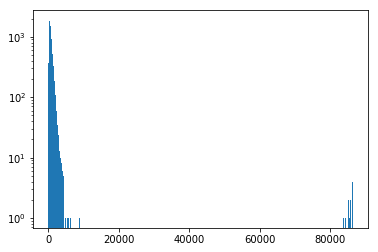

In [89]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.show()

Consindering the durations above 80k seconds (22 hours) as noise, let's zoom in a bit:

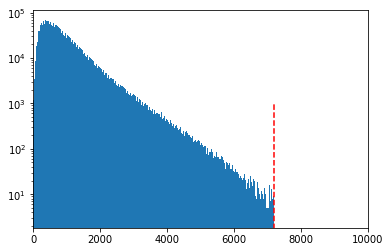

In [14]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.xlim(0,10000)
plt.plot((7200, 7200),(0,1e3), '--', c='r')
plt.show()

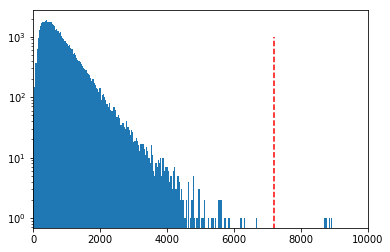

In [90]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.xlim(0,10000)
plt.plot((7200, 7200),(0,1e3), '--', c='r')
plt.show()

Seems reasonable to filter out any trips taking longer than 2 hours. 

In [91]:
print("{0:.2f}% of the trips last less than 2 hours".format(100*(df.duration < 7200).sum()/df.shape[0]))

99.83% of the trips last less than 2 hours


### Remove samples with too long duration (considered as outliers) 

In [92]:
print('# of duration outliers =', df[(df.duration > 7200)].shape[0])
handle_duration_outliers(df, 7200)

# of duration outliers = 83
Size reduction from 48804 to 48721 (83 samples dropped for having longer duration than 7200 seconds)


### Replot target histogram (duration) 

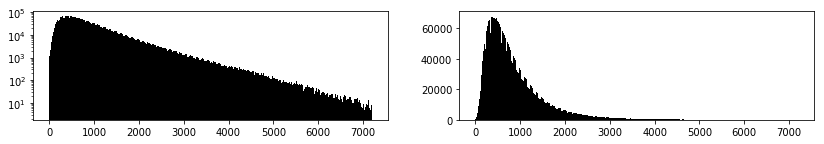

In [11]:
plt.figure(figsize=(14,2))
plt.subplot(1,2,1)
plt.hist(df.duration, bins='auto', log=True, color='k')
plt.subplot(1,2,2)
plt.hist(df.duration, bins='auto', log=False, color='k')
plt.show()

### Fit some distributions

- Normalize first:

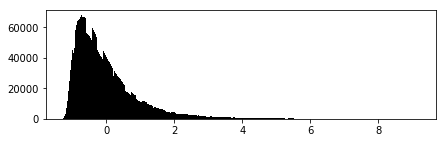

In [12]:
normalized_duration = (df.duration - df.duration.mean())/df.duration.std()
plt.figure(figsize=(7,2))
_,x,_ = plt.hist(normalized_duration, bins='auto', color='k')

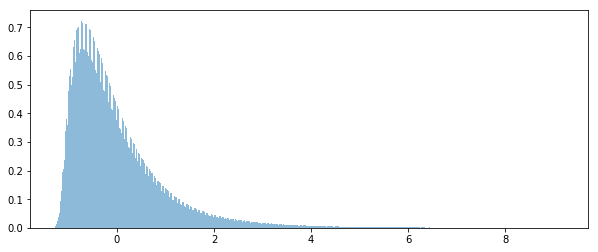

In [24]:
import numpy as np
from scipy import stats

plt.figure(figsize=(10,4))

plt.hist(normalized_duration[::1], bins='auto', alpha=0.5, density=True)

# dist_names = ['lognorm', 'gamma', 'norm', 'rayleigh']
# parameters = []

# left_x = np.linspace(x.min() - 2, x.min(), 1000)
# x_axis = np.concatenate((left_x, x))

# for dist_name in dist_names:
    
#     dist = getattr(stats, dist_name)
#     param = dist.fit(normalized_duration)
#     parameters.append(param)
    
#     shape = param[:-2]
#     loc = param[-2]
#     scale = param[-1]

#     pdf_fitted = dist.pdf(x_axis, *param[:-2], loc=param[-2], scale=param[-1])
#     plt.plot(x_axis, pdf_fitted, label=dist_name, linewidth=2)
#     plt.xlim((x_axis.min(),10))
#     plt.legend(loc='upper right')
plt.show()

### Pick-up / drop-off time histograms

In [8]:
# Measured in hours of a day
df['pu_hour'] = df.pu_t.apply(lambda s: s.hour)
df['do_hour'] = df.do_t.apply(lambda s: s.hour)

# Measured in seconds of a day
df['pu_second'] = df.pu_t.apply(lambda x : x.second + 60 * x.minute + 3600 * x.hour)
df['do_second'] = df.do_t.apply(lambda x : x.second + 60 * x.minute + 3600 * x.hour)

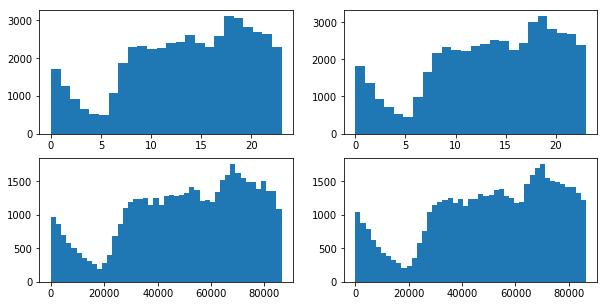

In [9]:
time_data = [df.pu_hour, df.do_hour, df.pu_second, df.do_second]

fig = plt.figure(figsize=(10,5))

ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

ax[0].hist(time_data[0], bins=24)
ax[1].hist(time_data[1], bins=24)
ax[2].hist(time_data[2], bins='auto')
ax[3].hist(time_data[3], bins='auto')

plt.show()  

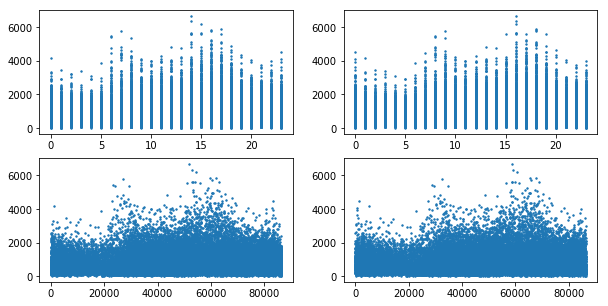

In [10]:
fig = plt.figure(figsize=(10,5))

ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
ax[0].scatter(time_data[0], df.duration, s=2)
ax[1].scatter(time_data[1], df.duration, s=2)
ax[2].scatter(time_data[2], df.duration, s=2)
ax[3].scatter(time_data[3], df.duration, s=2)

plt.show()

--------
### Generating plots for project report

In [3]:
import pickle as pkl

In [4]:
df = pkl.load(open('../data/dataset_10M.pkl', 'rb'))
df = df.drop('index',axis=1)

#Randomly select 10% of the dataset to raise some statistics
df = df.sample(n = int(0.1 * len(df))).reset_index()
df = df.drop('index',axis=1)

df.head()

,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-18 12:50:37,2016-02-18 13:04:11,2.50,-73.955284,40.782970,-73.984756,40.771740,814,1.729315,1.445659
1,2016-01-16 17:16:39,2016-01-16 17:43:32,11.10,-73.981873,40.768642,-73.898918,40.895798,1613,9.792312,1.133542
2,2016-02-05 20:08:49,2016-02-05 20:18:55,1.80,-73.979057,40.781769,-73.954498,40.782463,606,1.289035,1.396394
3,2016-01-22 02:25:34,2016-01-22 02:28:55,0.81,-73.971748,40.761059,-73.970222,40.752560,201,0.591905,1.368464
4,2016-01-18 11:24:00,2016-01-18 11:33:42,1.50,-73.971558,40.757938,-73.990356,40.751385,582,1.085142,1.382308


In [5]:
print(len(df))

1000000


### 1) Output distribution

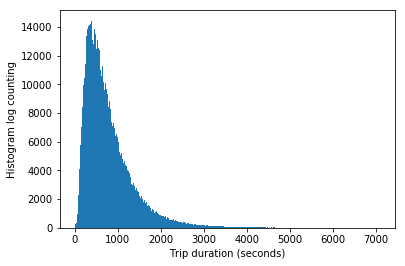

In [6]:
plt.figure()
plt.hist(df.duration, bins='auto', log=False)
plt.ylabel('Histogram log counting')
plt.xlabel('Trip duration (seconds)')
plt.show()

Computing distributions...
Distribution lognorm
Distribution gamma
Distribution norm
Distribution rayleigh


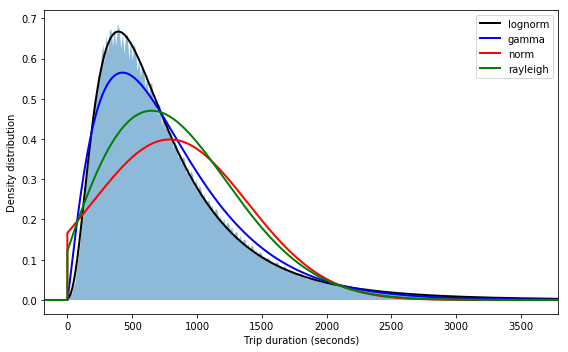

Done.


In [7]:
import numpy as np
from scipy import stats

normalize = False

normalized_duration = (df.duration - df.duration.mean())/df.duration.std()

y,x,_ = plt.hist(df.duration, bins='auto', alpha=0.5, density=True)
y_normalized,x_normalized,_ = plt.hist(normalized_duration, bins='auto', alpha=0.5, density=True)
plt.close()

dist_names = ['lognorm', 'gamma', 'norm', 'rayleigh']

colors = ['black','blue','red','green']

parameters = []

#Pick
if not normalize:
    x_axis = x; y_axis = np.sum(y_normalized)/np.sum(y) * y; left_wing = 0.3 * df.duration.std()
else:
    x_axis = x_normalized; y_axis = y_normalized; left_wing = 0.3

left_x = np.linspace(x_axis.min() - left_wing, x_axis.min(), 1000)

x_axis = np.concatenate((left_x, x_axis))
y_axis = np.concatenate((np.zeros(len(left_x)+1), y_axis))

# Plot distribution
plt.figure(figsize=(8,5))
plt.fill(x_axis, y_axis, alpha = 0.5)

print('Computing distributions...')

#distributions = []

for index, dist_name in enumerate(dist_names):
    
    print('Distribution', dist_name)
    
    dist = getattr(stats, dist_name)
    param = dist.fit(normalized_duration)
    parameters.append(param)
    
    shape = param[:-2]
    loc = param[-2]
    scale = param[-1]
    
    pdf_fitted = dist.pdf(x_normalized, *param[:-2], loc=param[-2], scale=param[-1])
    pdf_fitted = np.concatenate((np.zeros_like(left_x), pdf_fitted))

    plt.plot(x_axis, pdf_fitted, label=dist_name, linewidth=2, c=colors[index])
    
plt.xlim((x_axis.min(), 5 * df.duration.std() + df.duration.mean()))
plt.xlabel('Trip duration (seconds)')
if normalize:
    plt.xlim((x_axis.min(),5))
    plt.xlabel('Trip duration (normalized by standard deviation)')

plt.ylabel('Density distribution')
plt.legend(loc='upper right')

plt.tight_layout()

if normalize:
    plt.savefig('../figures/trip_duration_distribution_norm.png', dpi=500, bbox='tight');    
else:
    plt.savefig('../figures/trip_duration_distribution.png', dpi=500, bbox='tight');    
plt.show()

print('Done.')

In [14]:
100*len(df[df.duration < 2000])/len(df)

95.5263

### 2) Hour of trip distribution

In [25]:
df.head()

,original_index,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,fare_amount,tip_amount,total_amount,duration,vec_dist,trip_ratio,pu_lon_n,pu_lat_n,do_lon_n,do_lat_n,avg_hour,week_day
0,0,2016-04-16 15:32:19,2016-04-16 15:48:38,1.66,-73.989342,40.734261,-73.973190,40.749870,11.5,1.00,13.30,979,1.370661,1.211095,0.482712,0.565804,0.511615,0.593738,15,5
1,1,2016-04-23 22:55:51,2016-04-23 23:04:15,3.00,-73.967606,40.762981,-73.939804,40.798103,10.5,0.00,11.80,504,2.828417,1.060664,0.521609,0.617200,0.571359,0.680050,23,5
2,2,2016-04-03 01:18:07,2016-04-03 01:29:10,4.24,-73.968681,40.754639,-73.994118,40.709721,13.5,0.00,14.80,663,3.374803,1.256370,0.519684,0.602271,0.474166,0.521890,1,6
3,3,2016-04-27 15:16:36,2016-04-27 15:19:59,0.64,-73.963608,40.777000,-73.972328,40.782280,4.5,0.00,5.30,203,0.584758,1.094470,0.528763,0.642287,0.513158,0.651734,15,2
4,4,2016-04-26 07:33:33,2016-04-26 07:57:27,5.90,-73.965652,40.754841,-73.990768,40.745171,21.5,4.46,26.76,1434,1.477279,3.993828,0.525104,0.602632,0.480159,0.585328,7,1


In [27]:
df.head()

,original_index,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,fare_amount,tip_amount,total_amount,duration,vec_dist,trip_ratio,pu_lon_n,pu_lat_n,do_lon_n,do_lat_n,avg_hour,week_day
0,0,2016-04-16 15:32:19,2016-04-16 15:48:38,1.66,-73.989342,40.734261,-73.973190,40.749870,11.5,1.00,13.30,979,1.370661,1.211095,0.482712,0.565804,0.511615,0.593738,15,5
1,1,2016-04-23 22:55:51,2016-04-23 23:04:15,3.00,-73.967606,40.762981,-73.939804,40.798103,10.5,0.00,11.80,504,2.828417,1.060664,0.521609,0.617200,0.571359,0.680050,23,5
2,2,2016-04-03 01:18:07,2016-04-03 01:29:10,4.24,-73.968681,40.754639,-73.994118,40.709721,13.5,0.00,14.80,663,3.374803,1.256370,0.519684,0.602271,0.474166,0.521890,1,6
3,3,2016-04-27 15:16:36,2016-04-27 15:19:59,0.64,-73.963608,40.777000,-73.972328,40.782280,4.5,0.00,5.30,203,0.584758,1.094470,0.528763,0.642287,0.513158,0.651734,15,2
4,4,2016-04-26 07:33:33,2016-04-26 07:57:27,5.90,-73.965652,40.754841,-73.990768,40.745171,21.5,4.46,26.76,1434,1.477279,3.993828,0.525104,0.602632,0.480159,0.585328,7,1


In [28]:
#df['trip_hour'] = df.apply(lambda s: pd.Timestamp(np.mean((s.pu_t.value, s.do_t.value))).hour, axis = 1)

In [29]:
# Monday == 0 … Sunday == 6
#df['week_day'] = df.apply(lambda s: pd.Timestamp(np.mean((s.pu_t.value, s.do_t.value))).weekday(), axis = 1)

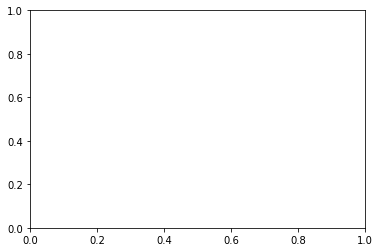

In [36]:
fig = plt.figure()
a1 = fig.gca()

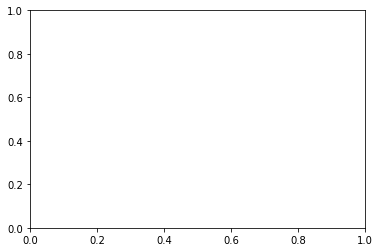

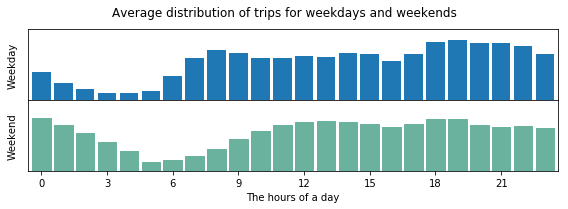

In [114]:
day = ['MON','TUE','WED','THU','FRI','SAT','SUN']
group = ['Weekday', 'Weekend']
bins = []

fig = plt.figure()
ax1 = fig.gca()
for d in range(7):
    y,x,_ = ax1.hist(df[df.week_day == d].avg_hour, bins=24, density=True)
    bins.append(y)
plt.close()

grouped_bins = [\
    np.mean(np.array(bins[:5]), axis=0),
    np.mean(np.array(bins[5:]), axis=0)]

fig = plt.figure(figsize=(8,8))
x = np.arange(24)
max_y = 0.08
plt.ylim((0,max_y))

ax0 = None
for d in range(0,2):
    ax1 = plt.subplot(7,1,d+1, sharex = ax0)
    bars = ax1.bar(x, grouped_bins[d], width=0.85)
    plt.ylim((0,max_y))
    ax1.yaxis.set_visible(True)
    ax1.set_yticklabels([])
    ax1.set_ylabel(group[d])
    ax1.tick_params(axis='y', left=False)
    if d == 0:
        ax0 = ax1
    if d > 0:
        [bar.set_color('#6bb29e') for bar in bars]

fig.suptitle('Average distribution of trips for weekdays and weekends') # or plt.suptitle('Main title')

fig.tight_layout()
fig.subplots_adjust(top=0.94, bottom = 0.08)

ax1.xaxis.set_ticks(np.arange(0,24,3))
plt.xlabel('The hours of a day')
plt.xlim((-0.6 + 0, 23 + 0.6))
plt.subplots_adjust(hspace=.0)

plt.savefig('../figures/trip_weekday_weekend_distrib.png', dpi=500);    
plt.show()

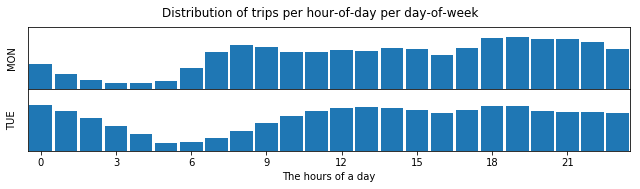

In [77]:
fig = plt.figure(figsize=(9,7))
x = np.arange(24)
max_y = 0.08
plt.ylim((0,max_y))

ax0 = None
for d in range(0,7):
    ax1 = plt.subplot(7,1,d+1, sharex = ax0)
    bars = ax1.bar(x, bins[d], width=.9)
    plt.ylim((0,max_y))
    ax1.yaxis.set_visible(True)
    ax1.set_yticklabels([])
    ax1.set_ylabel(day[d])
    ax1.tick_params(axis='y', left=False)
    if d == 0:
        ax0 = ax1
    if d > 4:
        [bar.set_color('#6bb29e') for bar in bars]

fig.suptitle('Distribution of trips per hour-of-day per day-of-week') # or plt.suptitle('Main title')

fig.tight_layout()
fig.subplots_adjust(top=0.94, bottom = 0.08)

ax1.xaxis.set_ticks(np.arange(0,24,3))
plt.xlabel('The hours of a day')
plt.xlim((-.5,23.5))
plt.subplots_adjust(hspace=.0)

#plt.savefig('../figures/trip_per_day_distribution.png', dpi=500);    
plt.show()

[array([0.03177512, 0.01916265, 0.0120879 , 0.00791079, 0.00745522,
        0.01062102, 0.02708727, 0.04722288, 0.05668697, 0.05351783,
        0.04772608, 0.04748302, 0.04980011, 0.04908032, 0.05274052,
        0.05197516, 0.04426328, 0.05253147, 0.06590691, 0.06746381,
        0.06431542, 0.06398847, 0.06074528, 0.05193076]),
 array([0.05938694, 0.05155252, 0.04294346, 0.03246617, 0.02207433,
        0.01018817, 0.01168208, 0.01636389, 0.02495575, 0.03592709,
        0.04540317, 0.05171955, 0.05557299, 0.05629898, 0.05510413,
        0.05273489, 0.04928155, 0.0524236 , 0.05840642, 0.0583507 ,
        0.05205666, 0.04974472, 0.05041706, 0.04842345])]

In [61]:
# week day



for i in range(5):
    print(bins[i])

[0.02657044 0.01646748 0.01040001 0.00713401 0.00753456 0.01121375
 0.02729727 0.0456079  0.05498877 0.05284145 0.04701179 0.04782947
 0.05059143 0.05075734 0.05557418 0.05740943 0.05167615 0.06068175
 0.07113233 0.06777073 0.06318221 0.06202086 0.05521867 0.04256626]
[0.02542715 0.01424367 0.00880215 0.00559317 0.00577344 0.01050392
 0.02838934 0.05006315 0.05970653 0.05599968 0.04947229 0.04847798
 0.05035501 0.04949232 0.05367915 0.05407973 0.04645502 0.05462195
 0.06852155 0.06762667 0.0650293  0.06500355 0.05983099 0.04633055]
[0.02979434 0.01668781 0.01020314 0.00662269 0.0065647  0.00983317
 0.02712534 0.04929326 0.0584894  0.05453489 0.04825686 0.04838835
 0.05031415 0.04933164 0.05249639 0.05050199 0.04207601 0.05001523
 0.0646433  0.06767165 0.06699297 0.06753526 0.06369673 0.052409  ]
[0.0330315  0.01962713 0.01208643 0.0077088  0.00704035 0.01050805
 0.02682453 0.04709722 0.056442   0.05289618 0.04743026 0.04665606
 0.04951766 0.04975126 0.05209515 0.04988937 0.04061877 0.0